In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/sarah/ML/master_thesis/Datasets/shuffled_data.csv")# Load mapping and clinical data
id_map = pd.read_csv("/Users/sarah/ML/master_thesis/Datasets/patient_id_mapping.csv")
id_map.columns = ['Anon.Patient_ID', 'study_id']
clinical = pd.read_excel("/Users/sarah/Library/Mobile Documents/iCloud~md~obsidian/Documents/MSc Medizininformatik/Master Thesis/Data/219 patients.xlsx")

# Merge measurement data with mapping
df_with_id = df.merge(id_map, on="Anon.Patient_ID", how="left")

# Merge with clinical data
df_full = df_with_id.merge(clinical, left_on="study_id", right_on="study_id", how="left")


# Load the corrected shift & shunt file
shift_shunt_df = pd.read_csv("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/patient_id_mappin_bpressure_corrected_shift_shunt.csv")

# Merge based on Anon.Patient_ID
df_full = df_full.merge(shift_shunt_df[['Anon.Patient_ID', 'shift', 'shunt']], on='Anon.Patient_ID', how='left')

# Drop the old 2C-based columns if they exist
df_full = df_full.drop(columns=[col for col in ['shift_2C', 'shunt_2C'] if col in df_full.columns])

output_folder = "/Users/sarah/Library/Mobile Documents/iCloud~md~obsidian/Documents/MSc Medizininformatik/Master Thesis/Writing/Plots"



Mann–Whitney U test: U = 582882.50, p = 0.0000
Kruskal–Wallis H test: H = 872.68, p = 0.0000


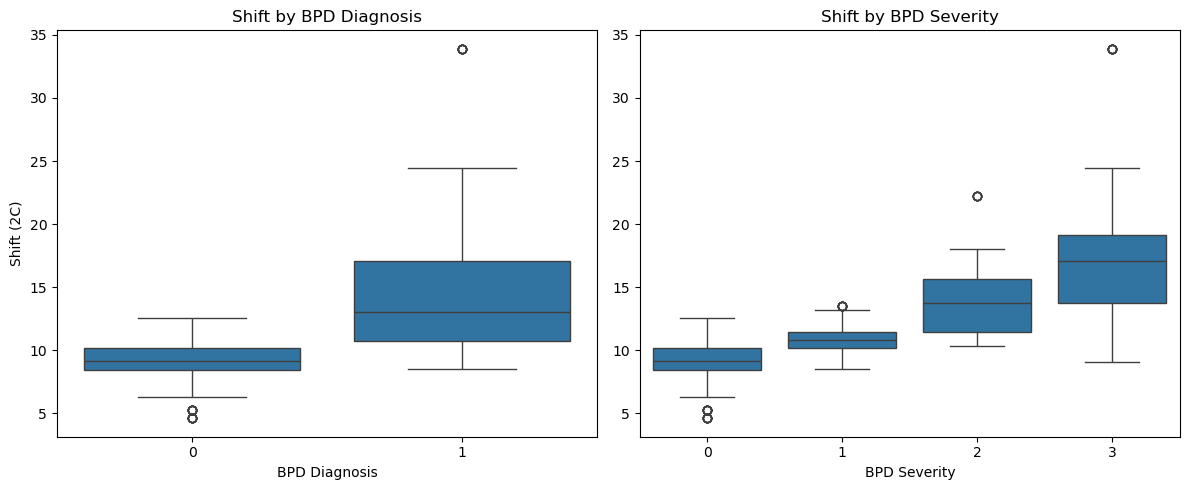

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal
import os

# ========== Variables ==========
feature = 'shift'
group_col_binary = 'BPD_yn'
group_col_severity = 'BPD_severity'

# ========== Statistical Tests ==========
# Mann–Whitney U test for BPD_yn (binary)
bpd_groups = df_full[group_col_binary].dropna().unique()
if len(bpd_groups) == 2:
    g1 = df_full[df_full[group_col_binary] == bpd_groups[0]][feature].dropna()
    g2 = df_full[df_full[group_col_binary] == bpd_groups[1]][feature].dropna()
    mann_whitney_result = mannwhitneyu(g1, g2, alternative='two-sided')
    p_binary = mann_whitney_result.pvalue
    u_stat = mann_whitney_result.statistic
    print(f"Mann–Whitney U test: U = {u_stat:.2f}, p = {p_binary:.4f}")
else:
    p_binary = None
    print("BPD_yn is not binary or contains NaNs.")

# Kruskal–Wallis H test for BPD_severity
severity_groups = df_full[group_col_severity].dropna().unique()
grouped_data = [df_full[df_full[group_col_severity] == sev][feature].dropna() for sev in severity_groups]
kruskal_result = kruskal(*grouped_data)
p_severity = kruskal_result.pvalue
h_stat = kruskal_result.statistic
print(f"Kruskal–Wallis H test: H = {h_stat:.2f}, p = {p_severity:.4f}")

# ========== Combined Boxplots ==========
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for BPD Diagnosis
sns.boxplot(ax=axes[0], data=df_full, x=group_col_binary, y=feature)
axes[0].set_title(f"Shift by BPD Diagnosis")
axes[0].set_xlabel("BPD Diagnosis")
axes[0].set_ylabel("Shift (2C)")

# Boxplot for BPD Severity
sns.boxplot(ax=axes[1], data=df_full, x=group_col_severity, y=feature)
axes[1].set_title(f"Shift by BPD Severity")
axes[1].set_xlabel("BPD Severity")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "shift_boxplot_combined.png"), dpi=300)
plt.show()


In [9]:

import numpy as np
import pandas as pd
from scipy.stats import rankdata

# Deskriptive Statistik: Median und IQR für Shift nach BPD (binary)
print("Deskriptive Statistik für Shift nach BPD (binary):")
for val in sorted(df_full['BPD_yn'].dropna().unique()):
    group = df_full[df_full['BPD_yn'] == val]['shift'].dropna()
    median = np.median(group)
    iqr = np.percentile(group, 75) - np.percentile(group, 25)
    print(f"BPD_yn = {val}: Median = {median:.2f}, IQR = {iqr:.2f} (n={len(group)})")

print("\nDeskriptive Statistik für Shift nach BPD-Schweregrad:")
for val in sorted(df_full['BPD_severity'].dropna().unique()):
    group = df_full[df_full['BPD_severity'] == val]['shift'].dropna()
    median = np.median(group)
    iqr = np.percentile(group, 75) - np.percentile(group, 25)
    print(f"BPD_severity = {val}: Median = {median:.2f}, IQR = {iqr:.2f} (n={len(group)})")

# Effektstärke: Rank-Biserial-Korrelation für BPD (binary)
bpd_groups = df_full['BPD_yn'].dropna().unique()
if len(bpd_groups) == 2:
    g1 = df_full[df_full['BPD_yn'] == bpd_groups[0]]['shift'].dropna()
    g2 = df_full[df_full['BPD_yn'] == bpd_groups[1]]['shift'].dropna()
    u_stat = mannwhitneyu(g1, g2, alternative='two-sided').statistic
    n1 = len(g1)
    n2 = len(g2)
    # Rank-Biserial-Korrelation
    rbc = 1 - (2 * u_stat) / (n1 * n2)
    print(f"\nRank-Biserial-Korrelation (BPD_yn): {rbc:.3f}")
else:
    print("\nRank-Biserial-Korrelation nicht berechenbar (BPD_yn ist nicht binär).")


Deskriptive Statistik für Shift nach BPD (binary):
BPD_yn = 0: Median = 9.11, IQR = 1.76 (n=979)
BPD_yn = 1: Median = 13.06, IQR = 6.33 (n=655)

Deskriptive Statistik für Shift nach BPD-Schweregrad:
BPD_severity = 0: Median = 9.11, IQR = 1.76 (n=979)
BPD_severity = 1: Median = 10.83, IQR = 1.26 (n=214)
BPD_severity = 2: Median = 13.75, IQR = 4.23 (n=174)
BPD_severity = 3: Median = 17.06, IQR = 5.37 (n=267)

Rank-Biserial-Korrelation (BPD_yn): -0.818


In [10]:

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Deskriptive Statistik: Median, IQR, 25. und 75. Perzentil für Shift nach BPD (binary)
print("Deskriptive Statistik für Shift nach BPD (binary):")
for val in sorted(df_full['BPD_yn'].dropna().unique()):
    group = df_full[df_full['BPD_yn'] == val]['shift'].dropna()
    median = np.median(group)
    q25 = np.percentile(group, 25)
    q75 = np.percentile(group, 75)
    iqr = q75 - q25
    print(f"BPD_yn = {val}: Median = {median:.2f}, 25% = {q25:.2f}, 75% = {q75:.2f}, IQR = {iqr:.2f} (n={len(group)})")

print("\nDeskriptive Statistik für Shift nach BPD-Schweregrad:")
for val in sorted(df_full['BPD_severity'].dropna().unique()):
    group = df_full[df_full['BPD_severity'] == val]['shift'].dropna()
    median = np.median(group)
    q25 = np.percentile(group, 25)
    q75 = np.percentile(group, 75)
    iqr = q75 - q25
    print(f"BPD_severity = {val}: Median = {median:.2f}, 25% = {q25:.2f}, 75% = {q75:.2f}, IQR = {iqr:.2f} (n={len(group)})")

# Effektstärke: Rank-Biserial-Korrelation für BPD (binary)
bpd_groups = df_full['BPD_yn'].dropna().unique()
if len(bpd_groups) == 2:
    g1 = df_full[df_full['BPD_yn'] == bpd_groups[0]]['shift'].dropna()
    g2 = df_full[df_full['BPD_yn'] == bpd_groups[1]]['shift'].dropna()
    u_stat = mannwhitneyu(g1, g2, alternative='two-sided').statistic
    n1 = len(g1)
    n2 = len(g2)
    # Rank-Biserial-Korrelation
    rbc = 1 - (2 * u_stat) / (n1 * n2)
    print(f"\nRank-Biserial-Korrelation (BPD_yn): {rbc:.3f}")
else:
    print("\nRank-Biserial-Korrelation nicht berechenbar (BPD_yn ist nicht binär).")


Deskriptive Statistik für Shift nach BPD (binary):
BPD_yn = 0: Median = 9.11, 25% = 8.40, 75% = 10.17, IQR = 1.76 (n=979)
BPD_yn = 1: Median = 13.06, 25% = 10.73, 75% = 17.06, IQR = 6.33 (n=655)

Deskriptive Statistik für Shift nach BPD-Schweregrad:
BPD_severity = 0: Median = 9.11, 25% = 8.40, 75% = 10.17, IQR = 1.76 (n=979)
BPD_severity = 1: Median = 10.83, 25% = 10.14, 75% = 11.41, IQR = 1.26 (n=214)
BPD_severity = 2: Median = 13.75, 25% = 11.40, 75% = 15.63, IQR = 4.23 (n=174)
BPD_severity = 3: Median = 17.06, 25% = 13.76, 75% = 19.13, IQR = 5.37 (n=267)

Rank-Biserial-Korrelation (BPD_yn): -0.818


In [17]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import os

# Tabelle für BPD_yn (binary)
rows = []
for val in sorted(df_full['BPD_yn'].dropna().unique()):
    group = df_full[df_full['BPD_yn'] == val]['shift'].dropna()
    median = np.round(np.median(group), 2)
    q25 = np.round(np.percentile(group, 25), 2)
    q75 = np.round(np.percentile(group, 75), 2)
    iqr = np.round(q75 - q25, 2)
    n = int(len(group))
    rows.append({'Grouping': 'BPD_yn', 'Group': val, 'n': n, 'Median': median, 'Q25': q25, 'Q75': q75, 'IQR': iqr})

# Tabelle für BPD_severity
for val in sorted(df_full['BPD_severity'].dropna().unique()):
    group = df_full[df_full['BPD_severity'] == val]['shift'].dropna()
    median = np.round(np.median(group), 2)
    q25 = np.round(np.percentile(group, 25), 2)
    q75 = np.round(np.percentile(group, 75), 2)
    iqr = np.round(q75 - q25, 2)
    n = int(len(group))
    rows.append({'Grouping': 'BPD_severity', 'Group': val, 'n': n, 'Median': median, 'Q25': q25, 'Q75': q75, 'IQR': iqr})

df_all = pd.DataFrame(rows)

# Tabelle anzeigen
print("Deskriptive Statistik für BPD_yn und BPD_severity gemeinsam:")
display(df_all)

# Export als Excel im output_folder
excel_path = os.path.join(output_folder, "shift_deskriptiv_BPD_combined.xlsx")
df_all.to_excel(excel_path, index=False, float_format='%.2f')
print(f"\nExcel-Datei wurde gespeichert: {excel_path}")


Deskriptive Statistik für BPD_yn und BPD_severity gemeinsam:


,Grouping,Group,n,Median,Q25,Q75,IQR
0,BPD_yn,0,979,9.11,8.40,10.17,1.77
1,BPD_yn,1,655,13.06,10.73,17.06,6.33
2,BPD_severity,0,979,9.11,8.40,10.17,1.77
3,BPD_severity,1,214,10.83,10.14,11.41,1.27
4,BPD_severity,2,174,13.75,11.40,15.63,4.23
5,BPD_severity,3,267,17.06,13.76,19.13,5.37



Excel-Datei wurde gespeichert: /Users/sarah/Library/Mobile Documents/iCloud~md~obsidian/Documents/MSc Medizininformatik/Master Thesis/Writing/Plots/shift_deskriptiv_BPD_combined.xlsx


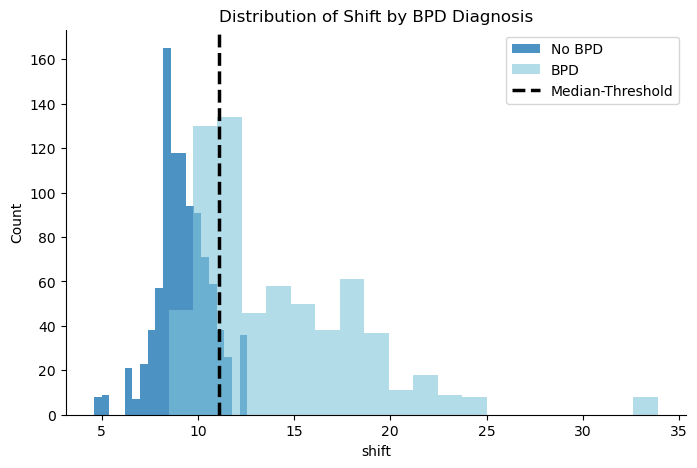

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
group_0 = df_full[df_full['BPD_yn'] == 0]['shift'].dropna()
group_1 = df_full[df_full['BPD_yn'] == 1]['shift'].dropna()

# Plot
plt.figure(figsize=(8, 5))
# Verwende zwei noch besser unterscheidbare Blautöne
plt.hist(group_0, bins=20, alpha=0.8, label='No BPD', color='#1f77b4')  # kräftiges Blau
plt.hist(group_1, bins=20, alpha=0.6, label='BPD', color="#80c5da61")     # cyan-blau

# Add vertical threshold line (Median beider Gruppen)
median_0 = np.median(group_0)
median_1 = np.median(group_1)
threshold = (median_0 + median_1) / 2
plt.axvline(threshold, color='black', linestyle='--', linewidth=2.5, label='Median-Threshold')

# Customize axes
plt.xlabel("shift")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Shift by BPD Diagnosis")

# Optional: remove top/right spines to match your style
sns.despine()

# Save (optional)
plt.savefig(os.path.join(output_folder, "histogram_shift2C_bpd_overlay.png"), dpi=300)

plt.show()


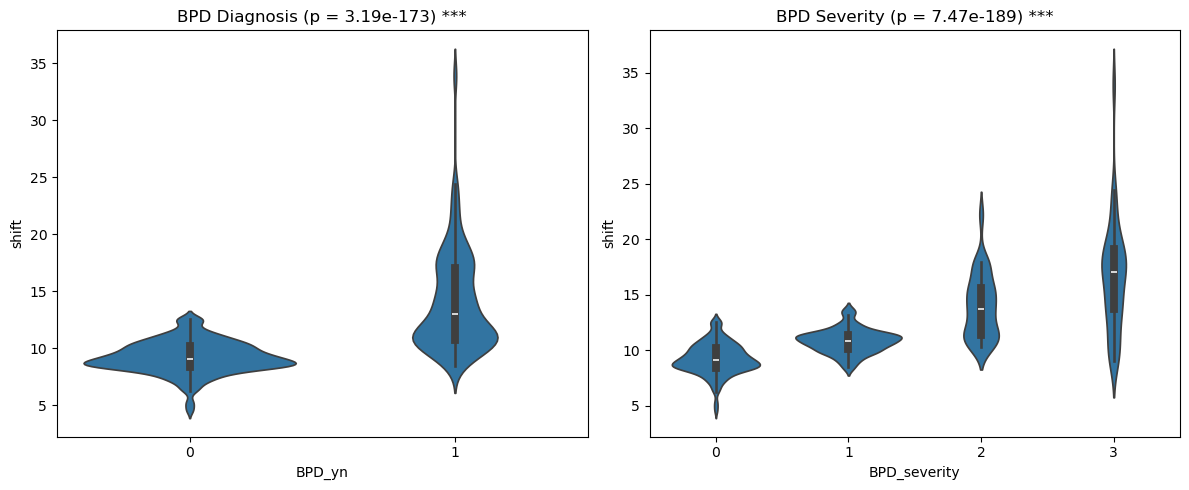

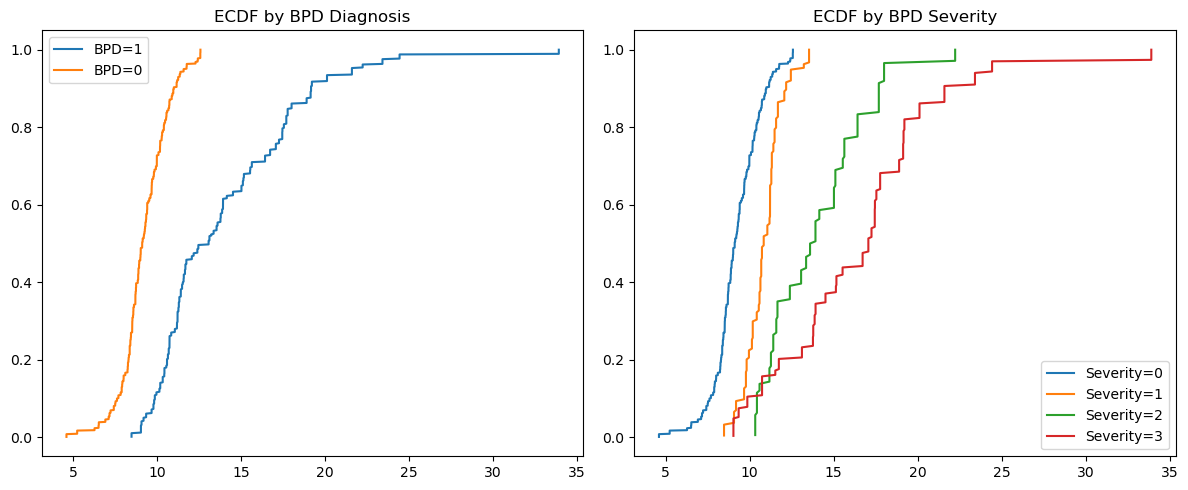

KeyError: "['shift_2C', 'shunt_2C'] not in index"

<Figure size 500x400 with 0 Axes>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal, spearmanr
from statsmodels.distributions.empirical_distribution import ECDF
import os

numeric_vars = ['shift_2C', 'Hb', 'shunt_2C']


# ========== Helper ==========
def get_sig_label(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# === 1. Violin Plots with Annotated p-values ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.violinplot(ax=axes[0], x=group_col_binary, y=feature, data=df_full, inner="box")
g1 = df_full[df_full[group_col_binary] == 0][feature].dropna()
g2 = df_full[df_full[group_col_binary] == 1][feature].dropna()
p1 = mannwhitneyu(g1, g2).pvalue
axes[0].set_title(f"BPD Diagnosis (p = {p1:.3g}) {get_sig_label(p1)}")

sns.violinplot(ax=axes[1], x=group_col_severity, y=feature, data=df_full, inner="box")
groups = [df_full[df_full[group_col_severity] == s][feature].dropna() for s in sorted(df_full[group_col_severity].dropna().unique())]
p2 = kruskal(*groups).pvalue
axes[1].set_title(f"BPD Severity (p = {p2:.3g}) {get_sig_label(p2)}")
plt.tight_layout()
# plt.savefig(os.path.join(output_folder, "violin_shift_bpd.png"), dpi=300)
plt.show()

# === 2. ECDF Plots ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for val in df_full[group_col_binary].dropna().unique():
    ecdf = ECDF(df_full[df_full[group_col_binary]==val][feature])
    axes[0].plot(ecdf.x, ecdf.y, label=f'BPD={val}')
axes[0].set_title("ECDF by BPD Diagnosis")
axes[0].legend()

for val in sorted(df_full[group_col_severity].dropna().unique()):
    ecdf = ECDF(df_full[df_full[group_col_severity]==val][feature])
    axes[1].plot(ecdf.x, ecdf.y, label=f'Severity={val}')
axes[1].set_title("ECDF by BPD Severity")
axes[1].legend()
plt.tight_layout()
# plt.savefig(os.path.join(output_folder, "ecdf_shift_bpd.png"), dpi=300)
plt.show()

# === 3. Correlation Heatmap ===
plt.figure(figsize=(5, 4))
corr = df_full[numeric_vars].corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Spearman Correlation")
# plt.savefig(os.path.join(output_folder, "correlation_heatmap.png"), dpi=300)
plt.show()

# === 4. Scatterplot Hb vs Shift ===
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_full, x='Hb', y='shift_2C', hue=group_col_binary, palette='Set2')
plt.title("Hb vs Shift by BPD Diagnosis")
plt.xlabel("Hemoglobin (g/dL)")
plt.ylabel("Shift")
plt.legend(title="BPD Diagnosis")
plt.tight_layout()
# plt.savefig(os.path.join(output_folder, "scatter_hb_shift_bpd.png"), dpi=300)
plt.show()

# === 5. KDE Overlay of Shift by BPD ===
plt.figure(figsize=(6, 5))
for val in df_full[group_col_binary].dropna().unique():
    sns.kdeplot(df_full[df_full[group_col_binary] == val][feature], fill=True, label=f'BPD={val}', alpha=0.4)
plt.title("KDE of Shift by BPD")
plt.xlabel("Shift")
plt.ylabel("Density")
plt.legend()
# plt.savefig(os.path.join(output_folder, "kde_shift_bpd.png"), dpi=300)
plt.show()